## Library Imports

In [64]:
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
from PIL import Image
import os
import random

## Image Matrix Construction (Constructing A) 
Dataset is taken from https://www.kaggle.com/code/jiaowoguanren/celebrity-face-image-dataset-tensorflow/input of 17 different celebrities. 

In [65]:
file_dict = ({})  # dictionary to hold path to each image (for reduced space & faster access time)


def create_vec(location, count_of_same_celebrity=40):
    """
    40 images of each celebrity has been randomly selected to create the image matrix as default.
    """
    # Create an empty list to store arrays
    img_arrays = []
    global file_dict

    idx = 0

    for celeb in os.listdir(location):
        celeb_path = os.path.join(location, celeb)
        if not os.path.isdir(celeb_path):
            continue  # Skip if the item in the directory is not a folder

        files = [f for f in os.listdir(celeb_path) if os.path.isfile(os.path.join(celeb_path, f))]
        
        # Use min() to avoid going beyond the available indices
        selected_files = random.sample(files, min(len(files), count_of_same_celebrity))

        for selected_file in selected_files:
            face_path = os.path.join(celeb_path, selected_file)
            file_dict[idx] = face_path
            idx += 1

            # Open and resize the face image
            face_image = Image.open(face_path).convert("L")  # Convert to grayscale
            resized_face_image = face_image.resize((20, 20))
            img_array = np.array(resized_face_image).flatten()
            img_arrays.append(img_array)

    # Convert the list of arrays into a NumPy array
    img_matrix = np.transpose(img_arrays)

    return img_matrix


A = create_vec("Cropped Celebrity Faces Dataset")

In [66]:
n = A.shape[0]
m = A.shape[1]  # Size of A
print("n =", n)
print("m =", m)

n = 400
m = 680


In [67]:
mean = np.mean(A, axis=1, keepdims=True)  # Mean face
B = A - mean  # Centering the images around mean face

## Constructing the matrix S

In [68]:
# Covariance
S = 1 / m * B @ B.T
S.shape

(400, 400)

## Zhang et al. Encryption Upon Correction (after implementing the proposed fix)

### Generation of U1 (Encrypted matrix)

In [69]:
alpha = np.random.rand()
gamma = np.random.rand()

# Making Block Matrix
G = np.diag(np.random.rand(n))
S1 = alpha * S + gamma * np.eye(n)
U = np.block([[S1, np.zeros((n, n))], [np.zeros((n, n)), G]])

# Multiplying orthogonal matrices
from scipy.sparse import rand

u1 = rand(2 * S.shape[0], 1)
u1 = u1.toarray()
u1 = u1 / np.linalg.norm(u1)
P = np.identity(2 * S.shape[0]) - 2 * (u1 @ u1.T)
U1 = P @ U @ P.T

## Outsourcing to Cloud

In [98]:
# Variables to Server
# U1
np.savetxt("U1.txt", U1, delimiter=",")

### The cloud performs the ED of U1 as V@D1@V.T and sends it back to client. Receiving the results from Cloud after ED 
(First the correct eigendecomposition to show the workability of Zhang et al.)

In [118]:
# Once we get results from server, we run the following code
V = np.loadtxt("V.txt", delimiter=",")  # Contains the eigenvectors such that V.T@V=I
D1 = np.loadtxt("D1.txt", delimiter=",")  # Contains the eigenvalues

## Zhang et al. Verification

In [119]:
l = int(input("No. of trials= "))

for i in range(l):
    e = np.random.choice([0, 1], size=(V.shape[0]))
    err = np.linalg.norm(V @ (D1 @ (V.T @ e)) - U1 @ e)

    if err >= 1e-4:
        print("Verification failed")
        break

else:
    print("Verification successful for all trials")

No. of trials= 80
Verification successful for all trials


### As the cloud-provided results pass the verification, we move to Decryption

In [120]:
U_block = P.T @ V  # Obtaining the original eigenvectors of B from the encrypted results
U = U_block[0 : S.shape[0], 0 : S.shape[1]]
D_block = D1[0 : S.shape[0], 0 : S.shape[1]] - gamma * np.eye(S.shape[0])
D_new = 1 / alpha * D_block
D_list = np.diag(D_new)  # Obtaining the original eigenvalues of B from the encrypted results
D_list.shape

(400,)

## Sorting eigenvectors and eigenvalues to perform PCA

In [121]:
sorted_indices = np.argsort(D_list)[::-1]
U_sorted = U[:, sorted_indices]
U_sorted.shape

(400, 400)

In [122]:
# Number of eigenfaces
num_components = 100
selected_U = U_sorted[:, :num_components]
selected_U.shape
# Project data onto selected eigenvectors (eigenfaces)
W = selected_U.T @ B  # B is left multiplied by principal components

W.shape  # Reduced dimensional matrix of the original matrix

(100, 680)

## Testing an image to confirm the PCA-based face recognition using Zhang et al. algorithm

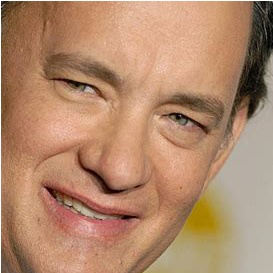

In [123]:
def preprocess_test_image(file_path, target_size=(20, 20)):
    img = Image.open(file_path).convert("L")  # Convert image to grayscale
    img_resized = img.resize(target_size, Image.LANCZOS)  # Resize image to a uniform size
    img_array = np.array(img_resized).flatten()  # Flatten the resized image to a single column vector
    return img_array


# Path to your test image file (replace with the actual path to your test image)
test_image_path = "Test/Tom Hanks/008_74cd0628.jpg"  # Taking Tom Hanks image as an example which is not included in the PCA training

from IPython.display import display
import matplotlib.pyplot as plt

img = Image.open(test_image_path)
display(img)

### We preprocess the test vector x with the same modifications as that the image matrix undergo.

In [124]:
# Load and preprocess the test image into a column vector
x = preprocess_test_image(test_image_path)

x_reshaped = x.reshape(-1, 1)
x_reshaped.shape

# Normalizing
x_norm = x_reshaped - mean  # Subtracting the mean face
# Transforming
x_trans = selected_U.T @ x_norm  # Left multiplied by Principal components

## Checking x_trans is closest to which column of the W (PCA reduced image matrix)

In [125]:
d = np.linalg.norm(x_trans - W, axis=0)
d_min = np.min(d)
d_index = np.argmin(d)

In [126]:
from IPython.display import display


def display_original(n):
    """
    n: a number less than A.shape[1] and the index of the image to be displayed
    """
    global file_dict
    display(Image.open(file_dict[n]))

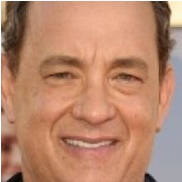

In [127]:
display_original(d_index)

### It has correctly detected the test image of Tom Hanks from the trained set!

# Now let's perform the proposed Cheating!
(Server provides the incorrect results)

In [128]:
# Once we get results from server, we run the following code
V_twisted = np.loadtxt("V_twisted.txt", delimiter=",")
D1_twisted = np.loadtxt("D1_twisted.txt", delimiter=",")
V_twisted.shape

(800, 800)

## Zhang et al. Verification

In [129]:
l = int(input("No. of trials= "))

for i in range(l):
    e1 = np.random.choice([0, 1], size=(V.shape[0]))
    err2 = np.linalg.norm(V_twisted @ (D1_twisted @ (V_twisted.T @ e1)) - U1 @ e1)

    if err2 >= 1e-4:
        print("Verification failed")
        break

else:
    print("Verification successful for all trials")

No. of trials= 80
Verification successful for all trials


## Cheated results pass the verification, leading to Incorrect Decryption!

In [130]:
U_twistedblock = P.T @ V_twisted
U_twisted = U_twistedblock[0 : S.shape[0], 0 : S.shape[1]]
D_twistedblock = D1_twisted[0 : S.shape[0], 0 : S.shape[1]] - gamma * np.eye(S.shape[0])
D_twistednew = 1 / alpha * D_twistedblock
D_twistedlist = np.diag(D_twistednew)
D_twistedlist.shape

(400,)

## Incorrect sorting (due to the cheating, the decreasing order of the eigenvalues is changed)

In [131]:
twisted_indices = np.argsort(D_twistedlist)[::-1]

U_twistedsorted = U_twisted[:, twisted_indices]
U_twistedsorted.shape

(400, 400)

## Now the client will get an incorrect reduced dimension matrix W_corrupted

In [132]:
# Number of twisted eigenfaces
num_components = 100
corrupted_U = U_twistedsorted[:, :num_components]

# Project data onto selected eigenvectors (eigenfaces)
W_corrupted = corrupted_U.T @ B

## Similarly the test image is also incorrectly transformed

In [133]:
# Twisted transformation of x
x_corrupted = corrupted_U.T @ x_norm

In [134]:
d_new = np.linalg.norm(x_corrupted - W_corrupted, axis=0)
d_newmin = np.min(d_new)
d_newindex = np.argmin(d_new)

# The cheating leads to the Incorrect detection of the test image

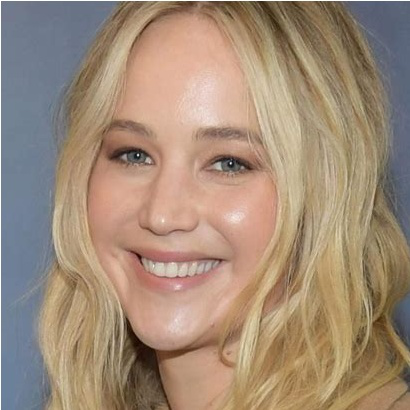

In [135]:
display_original(d_newindex)

## The test image of Tom Hanks is detected as Jennifer Lawrence upon cheating!

# New Robust Verification Method 
The proposed verification can detect cheating and make the algorithm more robust to 'cheating'

In [136]:
l = int(input("No. of trials"))
for i in range(l):
    e2 = np.random.choice([0, 1], size=(V.shape[0]))
    err2 = np.linalg.norm(V_twisted.T @ (V_twisted @ e2) - e2)

    if err2 >= 1e-4:
        print("Verification failed")
        break

    e1 = np.random.choice([0, 1], size=(V.shape[0]))
    err1 = np.linalg.norm(V_twisted @ (D1_twisted @ (V_twisted.T @ e1)) - U1 @ e1)

    if err1 >= 1e-4:
        print("Verification failed")
        break
else:
    print("Verification successful for all trials")

No. of trials1
Verification failed
